In [11]:
# load dependencies
import os
import matplotlib.pyplot as plt
import pystac_client
from odc.stac import stac_load
import xarray as xr
import rioxarray as rxr
import jinja2

In [12]:
# set data and output folder
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [13]:
# define location and time of interest
latitude = 27.163
longitude = 82.608
year = 2023

In [14]:
# search for sentinel imagery
catalog = pystac_client.Client.open(
    'https://earth-search.aws.element84.com/v1')

# Define a small bounding box around the chosen point
km2deg = 1.0 / 111
x, y = (longitude, latitude)
r = 1 * km2deg  # radius in degrees
bbox = (x - r, y - r, x + r, y + r)

search = catalog.search(
    collections=['sentinel-2-c1-l2a'],
    bbox=bbox,
    datetime=f'{year}',
    query={'eo:cloud_cover': {'lt': 30}},
)
items = search.item_collection()

In [15]:
# load imagery as xarray dataset
ds = stac_load(
    items,
    bands=['red', 'green', 'blue', 'nir'],
    resolution=10,
    bbox=bbox,
    chunks={},  # <-- use Dask
    groupby='solar_day',
)
ds

ImportError: Dask diagnostics requirements are not installed.

Please either conda or pip install as follows:

  conda install dask                     # either conda install
  python -m pip install "dask[diagnostics]" --upgrade  # or python -m pip install

<xarray.Dataset> Size: 21MB
Dimensions:      (y: 202, x: 182, time: 70)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 560B 2023-01-13T05:21:06.880000 ... 20...
Data variables:
    red          (time, y, x) uint16 5MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    green        (time, y, x) uint16 5MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    blue         (time, y, x) uint16 5MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    nir          (time, y, x) uint16 5MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>

In [16]:
%%time
ds = ds.compute()

CPU times: user 5.43 s, sys: 1.23 s, total: 6.66 s
Wall time: 31.9 s


In [17]:
da = ds.red
da

<xarray.DataArray 'red' (time: 70, y: 202, x: 182)> Size: 5MB
array([[[7592, 7548, 7388, ..., 7620, 7588, 7640],
        [7392, 7248, 7128, ..., 7632, 7680, 7744],
        [7164, 6976, 6844, ..., 7688, 7700, 7772],
        ...,
        [6512, 6560, 6592, ..., 8224, 8216, 8128],
        [6416, 6500, 6556, ..., 8160, 8152, 8128],
        [6396, 6528, 6604, ..., 7996, 7976, 7880]],

       [[1786, 1720, 1689, ..., 1888, 1772, 1808],
        [1834, 1752, 1724, ..., 1820, 1677, 1736],
        [1884, 1782, 1780, ..., 1742, 1652, 1694],
        ...,
        [1626, 1662, 1698, ..., 1878, 1824, 1724],
        [1656, 1690, 1641, ..., 1811, 1926, 2042],
        [1700, 1664, 1572, ..., 1836, 1922, 2044]],

       [[1585, 1530, 1465, ..., 1648, 1493, 1516],
        [1634, 1508, 1483, ..., 1590, 1459, 1523],
        [1736, 1616, 1518, ..., 1602, 1492, 1568],
        ...,
...
        ...,
        [   0,    0,    0, ..., 1816, 2152, 2354],
        [   0,    0,    0, ..., 1892, 2208, 2374],
        [   0,    0,    0, ..., 2094, 2102, 2156]],

       [[2318, 2258, 2078, ..., 1702, 1648, 1728],
        [2064, 2160, 1990, ..., 1666, 1604, 1718],
        [1778, 1906, 1808, ..., 1714, 1692, 1726],
        ...,
        [2002, 2042, 1971, ..., 1700, 2070, 2146],
        [1980, 2032, 2011, ..., 1722, 2132, 2124],
        [1880, 2000, 1930, ..., 1944, 2060, 1998]],

       [[   0,    0,    0, ..., 1821, 1762, 1830],
        [   0,    0,    0, ..., 1818, 1750, 1814],
        [   0,    0,    0, ..., 1776, 1816, 1832],
        ...,
        [2078, 2092, 2058, ..., 1899, 2152, 2302],
        [2080, 2084, 2090, ..., 1936, 2188, 2290],
        [1970, 2030, 2034, ..., 2038, 2198, 2240]]], dtype=uint16)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 560B 2023-01-13T05:21:06.880000 ... 20...
Attributes:
    nodata:   0

In [18]:
ds.info()

xarray.Dataset {
dimensions:
	y = 202 ;
	x = 182 ;
	time = 70 ;

variables:
	float64 y(y) ;
		y:units = metre ;
		y:resolution = -10.0 ;
		y:crs = EPSG:32644 ;
	float64 x(x) ;
		x:units = metre ;
		x:resolution = 10.0 ;
		x:crs = EPSG:32644 ;
	int32 spatial_ref() ;
		spatial_ref:spatial_ref = PROJCRS["WGS 84 / UTM zone 44N",BASEGEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],MEMBER["World Geodetic System 1984 (G2296)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4326]],CONVERSION["UTM zone 44N",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER

In [19]:
da.isel(time=-1)

<xarray.DataArray 'red' (y: 202, x: 182)> Size: 74kB
array([[   0,    0,    0, ..., 1821, 1762, 1830],
       [   0,    0,    0, ..., 1818, 1750, 1814],
       [   0,    0,    0, ..., 1776, 1816, 1832],
       ...,
       [2078, 2092, 2058, ..., 1899, 2152, 2302],
       [2080, 2084, 2090, ..., 1936, 2188, 2290],
       [1970, 2030, 2034, ..., 2038, 2198, 2240]], dtype=uint16)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
    time         datetime64[ns] 8B 2023-12-26T05:11:10.219000
Attributes:
    nodata:   0

In [20]:
da.isel(time=-1).values

array([[   0,    0,    0, ..., 1821, 1762, 1830],
       [   0,    0,    0, ..., 1818, 1750, 1814],
       [   0,    0,    0, ..., 1776, 1816, 1832],
       ...,
       [2078, 2092, 2058, ..., 1899, 2152, 2302],
       [2080, 2084, 2090, ..., 1936, 2188, 2290],
       [1970, 2030, 2034, ..., 2038, 2198, 2240]], dtype=uint16)

In [21]:
dates = da.time.values
dates

array(['2023-01-13T05:21:06.880000000', '2023-01-18T05:21:06.614000000',
       '2023-01-23T05:21:05.552000000', '2023-02-07T05:21:07.419000000',
       '2023-02-09T05:11:12.073000000', '2023-02-12T05:21:07.542000000',
       '2023-02-14T05:11:11.668000000', '2023-02-19T05:11:10.303000000',
       '2023-02-22T05:21:06.867000000', '2023-03-01T05:11:10.619000000',
       '2023-03-04T05:21:06.040000000', '2023-03-06T05:11:16.188000000',
       '2023-03-09T05:21:13.261000000', '2023-03-11T05:11:08.720000000',
       '2023-03-24T05:21:07.945000000', '2023-03-26T05:11:16.033000000',
       '2023-04-03T05:21:08.616000000', '2023-04-05T05:11:16.355000000',
       '2023-04-08T05:21:11.786000000', '2023-04-10T05:11:13.434000000',
       '2023-04-13T05:21:09.401000000', '2023-04-18T05:21:11.018000000',
       '2023-04-23T05:21:08.563000000', '2023-04-25T05:11:15.158000000',
       '2023-05-05T05:11:15.867000000', '2023-05-10T05:11:12.717000000',
       '2023-05-13T05:21:09.142000000', '2023-05-18

In [22]:
da.sel(time='2023-12-16')

<xarray.DataArray 'red' (time: 1, y: 202, x: 182)> Size: 74kB
array([[[   0,    0,    0, ..., 2156, 1974, 2021],
        [   0,    0,    0, ..., 2066, 1894, 1986],
        [   0,    0,    0, ..., 2084, 1965, 2013],
        ...,
        [   0,    0,    0, ..., 1816, 2152, 2354],
        [   0,    0,    0, ..., 1892, 2208, 2374],
        [   0,    0,    0, ..., 2094, 2102, 2156]]], dtype=uint16)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 8B 2023-12-16T05:11:09.255000
Attributes:
    nodata:   0

In [23]:
da.sel(time='2023-01-01', method='nearest')

<xarray.DataArray 'red' (y: 202, x: 182)> Size: 74kB
array([[7592, 7548, 7388, ..., 7620, 7588, 7640],
       [7392, 7248, 7128, ..., 7632, 7680, 7744],
       [7164, 6976, 6844, ..., 7688, 7700, 7772],
       ...,
       [6512, 6560, 6592, ..., 8224, 8216, 8128],
       [6416, 6500, 6556, ..., 8160, 8152, 8128],
       [6396, 6528, 6604, ..., 7996, 7976, 7880]], dtype=uint16)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
    time         datetime64[ns] 8B 2023-01-13T05:21:06.880000
Attributes:
    nodata:   0

In [24]:
da.sel(time=slice('2023-01-01', '2023-01-31'))

<xarray.DataArray 'red' (time: 3, y: 202, x: 182)> Size: 221kB
array([[[7592, 7548, 7388, ..., 7620, 7588, 7640],
        [7392, 7248, 7128, ..., 7632, 7680, 7744],
        [7164, 6976, 6844, ..., 7688, 7700, 7772],
        ...,
        [6512, 6560, 6592, ..., 8224, 8216, 8128],
        [6416, 6500, 6556, ..., 8160, 8152, 8128],
        [6396, 6528, 6604, ..., 7996, 7976, 7880]],

       [[1786, 1720, 1689, ..., 1888, 1772, 1808],
        [1834, 1752, 1724, ..., 1820, 1677, 1736],
        [1884, 1782, 1780, ..., 1742, 1652, 1694],
        ...,
        [1626, 1662, 1698, ..., 1878, 1824, 1724],
        [1656, 1690, 1641, ..., 1811, 1926, 2042],
        [1700, 1664, 1572, ..., 1836, 1922, 2044]],

       [[1585, 1530, 1465, ..., 1648, 1493, 1516],
        [1634, 1508, 1483, ..., 1590, 1459, 1523],
        [1736, 1616, 1518, ..., 1602, 1492, 1568],
        ...,
        [1536, 1599, 1593, ..., 1714, 1753, 1948],
        [1593, 1616, 1585, ..., 1726, 1788, 1928],
        [1574, 1585, 1567, ..., 1819, 1768, 1821]]], dtype=uint16)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 24B 2023-01-13T05:21:06.880000 ... 202...
Attributes:
    nodata:   0

In [25]:
median = ds.median(dim='time')
median

<xarray.Dataset> Size: 1MB
Dimensions:      (y: 202, x: 182)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
Data variables:
    red          (y, x) float64 294kB 2.144e+03 2.134e+03 ... 2.253e+03
    green        (y, x) float64 294kB 1.932e+03 1.942e+03 ... 2.154e+03 2.14e+03
    blue         (y, x) float64 294kB 1.744e+03 1.76e+03 ... 1.905e+03 1.93e+03
    nir          (y, x) float64 294kB 3.362e+03 3.371e+03 ... 3.741e+03

In [26]:
median_da = median.to_array('band')
median_da

<xarray.DataArray (band: 4, y: 202, x: 182)> Size: 1MB
array([[[2144. , 2134. , 2090. , ..., 2373. , 2291. , 2382. ],
        [2035. , 2145. , 2063. , ..., 2285. , 2129. , 2366. ],
        [1874.5, 1983.5, 1986. , ..., 2332. , 2173. , 2304. ],
        ...,
        [2122. , 2124. , 2185. , ..., 2153. , 2230. , 2423. ],
        [2126. , 2113. , 2199. , ..., 2163. , 2239. , 2379. ],
        [2355. , 2190. , 2281. , ..., 2206. , 2198. , 2253. ]],

       [[1932.5, 1942. , 1945. , ..., 2195. , 2135. , 2203. ],
        [1977.5, 1985.5, 1940.5, ..., 2131. , 2043. , 2204. ],
        [1960. , 1987. , 1943.5, ..., 2192. , 2075. , 2260. ],
        ...,
        [2053. , 2142. , 2194. , ..., 2166. , 2195. , 2347. ],
        [2124. , 2166. , 2229. , ..., 2156. , 2208. , 2298. ],
        [2185. , 2121. , 2255. , ..., 2188. , 2154. , 2140. ]],

       [[1744.5, 1760.5, 1755.5, ..., 2071. , 2037. , 2012. ],
        [1771.5, 1756.5, 1735. , ..., 1949. , 1825. , 1979. ],
        [1756.5, 1757.5, 1749. , ..., 1941.5, 1789. , 2016.5],
        ...,
        [1872.5, 1942. , 1964.5, ..., 1897. , 2009. , 2160. ],
        [1937. , 1975. , 2010.5, ..., 1928.5, 1967. , 2024. ],
        [1930.5, 1932. , 2053. , ..., 1979.5, 1905. , 1930. ]],

       [[3362. , 3371. , 3295. , ..., 3753.5, 3872. , 3946. ],
        [3371. , 3389. , 3287. , ..., 3540. , 3631. , 3909. ],
        [3366. , 3370. , 3189. , ..., 3734. , 3860. , 3836. ],
        ...,
        [3746. , 3756. , 3864. , ..., 3637. , 3516. , 3528. ],
        [3821. , 3789. , 3869. , ..., 3542. , 3883. , 3656. ],
        [3841. , 3873. , 3835. , ..., 3901.5, 4087. , 3741. ]]])
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * band         (band) object 32B 'red' 'green' 'blue' 'nir'

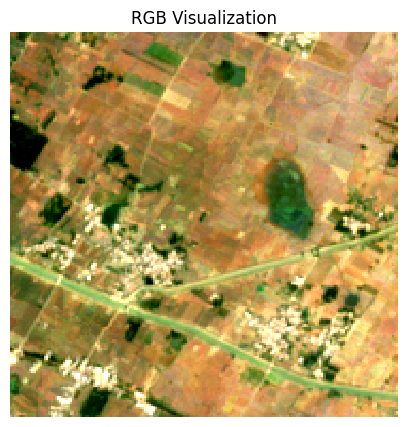

In [27]:
# plot median values
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
median_da.sel(band=['red', 'green', 'blue']).plot.imshow(
    ax=ax,
    robust=True)
ax.set_title('RGB Visualization')
ax.set_axis_off()
plt.show()

In [28]:
# aggregate data by month (median)
monthly = ds.groupby('time.month').median(dim='time')
monthly

<xarray.Dataset> Size: 14MB
Dimensions:      (month: 12, y: 202, x: 182)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * month        (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    red          (month, y, x) float64 4MB 1.786e+03 1.72e+03 ... 2.225e+03
    green        (month, y, x) float64 4MB 2.006e+03 1.976e+03 ... 2.191e+03
    blue         (month, y, x) float64 4MB 1.842e+03 1.802e+03 ... 2.016e+03
    nir          (month, y, x) float64 4MB 3.754e+03 3.972e+03 ... 3.232e+03

In [30]:
# convert monthly composites to dataarray
monthly_da = monthly.to_array('band')

In [31]:
monthly_da

<xarray.DataArray (band: 4, month: 12, y: 202, x: 182)> Size: 14MB
array([[[[1786. , 1720. , 1689. , ..., 1888. , 1772. , 1808. ],
         [1834. , 1752. , 1724. , ..., 1820. , 1677. , 1736. ],
         [1884. , 1782. , 1780. , ..., 1742. , 1652. , 1694. ],
         ...,
         [1626. , 1662. , 1698. , ..., 1878. , 1824. , 1948. ],
         [1656. , 1690. , 1641. , ..., 1811. , 1926. , 2042. ],
         [1700. , 1664. , 1572. , ..., 1836. , 1922. , 2044. ]],

        [[ 637. ,  620. ,  636. , ..., 1425. , 1409. , 1434.5],
         [ 649. ,  642.5,  624. , ..., 1415. , 1389. , 1414. ],
         [ 676. ,  669.5,  624. , ..., 1448.5, 1429. , 1435. ],
         ...,
         [1420. , 1537.5, 1518. , ..., 1748.5, 1856. , 2116. ],
         [1542. , 1558. , 1484. , ..., 1847. , 1923. , 2039. ],
         [1485.5, 1467. , 1454. , ..., 1843. , 1882. , 1848. ]],

        [[   0. ,    0. ,    0. , ..., 1430. , 1432. , 1498. ],
         [   0. ,    0. ,    0. , ..., 1430. , 1438. , 1453. ],
         [   0. ,    0. ,    0. , ..., 1460. , 1504. , 1495. ],
         ...,
...
         ...,
         [3899.5, 3828. , 4004. , ..., 3229. , 3325. , 3321. ],
         [3881. , 3790. , 3992. , ..., 3304. , 4058. , 3689. ],
         [3840. , 3845. , 4158. , ..., 3891.5, 4531.5, 4127. ]],

        [[3042. , 2982. , 2936. , ..., 3072. , 2996. , 3162. ],
         [3072. , 3028. , 2948. , ..., 3030. , 3012. , 3190. ],
         [3058. , 3050. , 2938. , ..., 3256. , 3374. , 3314. ],
         ...,
         [3126. , 3126. , 3166. , ..., 3384. , 3316. , 3406. ],
         [3178. , 3148. , 3172. , ..., 3348. , 3556. , 3430. ],
         [3270. , 3288. , 3200. , ..., 3408. , 3518. , 3270. ]],

        [[   0. ,    0. ,    0. , ..., 3128. , 3078. , 3346. ],
         [   0. ,    0. ,    0. , ..., 3085. , 3196. , 3325. ],
         [   0. ,    0. ,    0. , ..., 3427. , 3622. , 3429. ],
         ...,
         [1495. , 1490. , 1535. , ..., 3894. , 3466. , 3402. ],
         [1575. , 1482. , 1499. , ..., 3895. , 3682. , 3384. ],
         [1599. , 1537. , 1410. , ..., 3836. , 3603. , 3232. ]]]])
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * month        (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * band         (band) object 32B 'red' 'green' 'blue' 'nir'

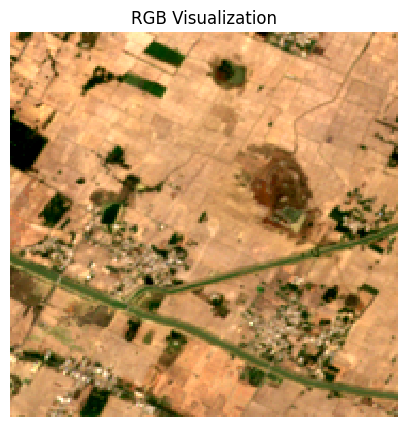

In [37]:
# plot true color of may values
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
monthly_da.sel(band=['red', 'green', 'blue'], month=5).plot.imshow(
    ax=ax,
    robust=True)
ax.set_title('RGB Visualization')
ax.set_axis_off()
plt.show()